<a href="https://colab.research.google.com/github/GRACOPORDEUS/atividades_mestrado/blob/main/1107106_220511_lista2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1ª Questão

"que tipo de pessoa tem mais probabilidade de sobreviver?"

### data manipulation

#### import from kaggle

In [147]:
!pip install kaggle

In [148]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [149]:
! cp kaggle.json ~/.kaggle/

In [150]:
! chmod 600 ~/.kaggle/kaggle.json

In [283]:
! kaggle competitions download -c titanic --force

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 30.9MB/s]


In [284]:
! unzip titanic.zip

Archive:  titanic.zip
replace gender_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


#### data preprocessing

In [285]:
titanic_train = pd.read_csv("train.csv")
titanic_test = pd.read_csv("test.csv")

Train

In [286]:
titanic_train.drop(['Name','Ticket','Cabin'],axis=1,inplace=True)
y = titanic_train.loc[:, 'Survived'].values

sex = pd.get_dummies(titanic_train['Sex'],drop_first=True)
embark = pd.get_dummies(titanic_train['Embarked'],drop_first=True)

titanic_train = pd.concat([titanic_train,sex,embark],axis=1)

titanic_train.drop(['Sex','Embarked'],axis=1,inplace=True)

titanic_train.fillna(titanic_train.mean(),inplace=True)

train_columns = titanic_train.columns
titanic_train = pd.DataFrame(StandardScaler().fit_transform(titanic_train))
titanic_train.columns  = train_columns

features = titanic_train.iloc[:,2:].columns.tolist()
target   = titanic_train.loc[:, 'Survived'].name

X = titanic_train.iloc[:,2:].values

In [287]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [288]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((712, 8), (712,), (179, 8), (179,))

Test

In [289]:
titanic_test.drop(['Name','Ticket','Cabin'],axis=1,inplace=True)

sex = pd.get_dummies(titanic_test['Sex'],drop_first=True)
embark = pd.get_dummies(titanic_test['Embarked'],drop_first=True)

titanic_test = pd.concat([titanic_test,sex,embark],axis=1)

titanic_test.drop(['Sex','Embarked'],axis=1,inplace=True)

titanic_test.fillna(titanic_test.mean(),inplace=True)

test_columns  = titanic_test.columns
titanic_test = pd.DataFrame(StandardScaler().fit_transform(titanic_test))
titanic_test.columns  = test_columns

In [290]:
test = titanic_test.iloc[:,1:].values

In [291]:
test.shape

(418, 8)

### Network

In [292]:
class dataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x).float()
        self.y = torch.from_numpy(y)
        self.n_sample = x.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.n_sample

In [293]:
train_dataset = dataset(X_train, y_train)
test_dataset = dataset(X_test, y_test)

In [294]:
# datasset parameters
input_size = X_train.shape[1]
batch_size = X_train.shape[0]
num_classes = 2

In [295]:
train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle = True)

test_loader = DataLoader(
    dataset = test_dataset,
    batch_size = batch_size,
    shuffle = True)

In [296]:
class NN(nn.Module):
  def __init__(self, input_size, num_classes, tx_dropout):
    super(NN, self).__init__()
    self.fc1 = nn.Linear(input_size, 50)
    self.fc2 = nn.Linear(50, 20)
    self.fc3 = nn.Linear(20, num_classes)
    
    self.dropout = nn.Dropout(tx_dropout)

    self.bn1 = nn.BatchNorm1d(50)
    self.bn2 = nn.BatchNorm1d(20)
  
  def forward(self, x):
    x = F.relu(self.bn1(self.fc1(x)))
    x = self.dropout(F.relu(self.bn2(self.fc2(x))))
    x = torch.sigmoid(self.fc3(x))
    return x

In [297]:
print(NN(input_size, num_classes, tx_dropout= 0))

NN(
  (fc1): Linear(in_features=8, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=2, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (bn1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [298]:
# Check accuracy on training & test to see how good our model
def valdation_metrics(loader, losses, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            x = x.reshape(x.shape[0], -1)

            outputs = model(x)
            _, predictions = torch.max(outputs, 1)
            num_samples += predictions.size(0)
            
            # accuracy
            y_real = y.cpu().detach().numpy()
            y_pred = predictions.cpu().detach().numpy()

            # validation losses
            loss = criterion(outputs, y)
            losses += loss.item() 
            
    accuracy = accuracy_score(y_real, y_pred)
    losses = (losses/num_samples)
    model.train()
    return accuracy, losses

In [299]:
# ploting evaluations
def network_plots(train, test, metric):
    fig, ax = plt.subplots(figsize=(8,5))

    ax.plot(train)
    ax.plot(test)

    ax.legend(('Train', 'Test'), loc="best")
    plt.show()
    print(f"The {metric} in train was {round(train[-1],2)} and in test was {round(test[-1],2)}.")

In [300]:
# hiperparameters
num_epochs = 200
learning_rate = 0.001
tx_dropout = 0.0

# Initialize network
model = NN(
    input_size=input_size, 
    num_classes=num_classes, 
    tx_dropout=tx_dropout
    ).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train Network
plot_train_losses = []
plot_test_losses = []
plot_train_accuracy = []
plot_test_accuracy = []

for epoch in tqdm(range(num_epochs)):
    train_losses = 0.0
    test_losses = 0.0
    
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)
        # Get to correct shape
        data = data.reshape(data.shape[0], -1)
        # forward
        outputs = model(data)
        loss = criterion(outputs, targets)
        # backward
        optimizer.zero_grad()
        loss.backward()
        # gradient descent or adam step
        optimizer.step()

    # metrics
    train_metric = valdation_metrics(train_loader, train_losses, model)
    test_metric = valdation_metrics(test_loader, test_losses, model)

    # cumulative losses
    plot_train_losses.append(train_metric[1])
    plot_test_losses.append(test_metric[1])

    # cumulative accuracy
    train_accuracy = (train_metric[0]*100).item()
    test_accuracy = (test_metric[0]*100).item()
    plot_train_accuracy.append(train_accuracy)
    plot_test_accuracy.append(test_accuracy)

100%|██████████| 200/200 [00:03<00:00, 62.44it/s]


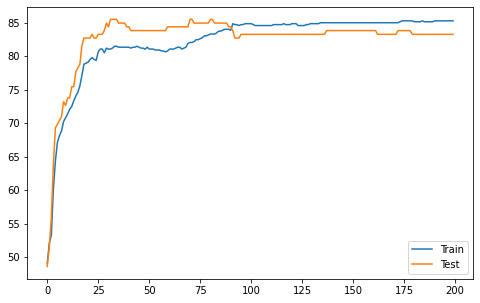

The Accuracy in train was 85.25 and in test was 83.24.


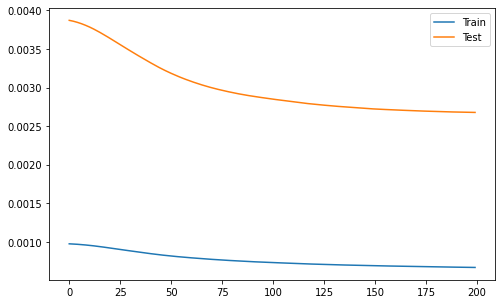

The Losses in train was 0.0 and in test was 0.0.


In [301]:
network_plots(plot_train_accuracy, plot_test_accuracy, 'Accuracy')
network_plots(plot_train_losses, plot_test_losses, 'Losses')

100%|██████████| 1/1 [00:00<00:00, 248.40it/s]

0.8324022346368715


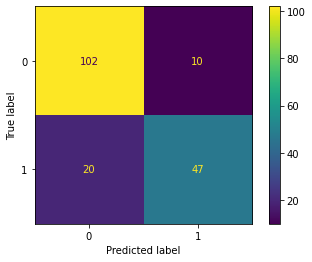

In [302]:
# test_loader
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for x, y in tqdm(test_loader):
        x = x.to(device=device)
        y = y.to(device=device)
        y = y.cpu().detach().numpy()
        
        x = x.reshape(x.shape[0], -1)
        outputs = model(x)

        predictions = torch.log_softmax(outputs, dim = 1)
        _, predictions = torch.max(predictions, 1)
        predictions = predictions.cpu().detach().numpy()

        y_true.append(y)
        y_pred.append(predictions)

model.train()

conf_matrix = confusion_matrix(
    y_true = y_true[0],
    y_pred = y_pred[0]
    )
labels = np.unique(y)

print(accuracy_score(y_true[0], y_pred[0]))


plot_cm = ConfusionMatrixDisplay(
    confusion_matrix = conf_matrix,
    display_labels = labels
    ) \
    .plot()

plt.show()

### Submission

In [303]:
class submission(Dataset):
    def __init__(self, x):
        self.x = torch.from_numpy(x).float()
        self.n_sample = x.shape[0]

    def __getitem__(self, index):
        return self.x[index]

    def __len__(self):
        return self.n_sample

sub_dataset = submission(test)
sub_loader = DataLoader(
    dataset = sub_dataset,
    batch_size = test.shape[0],
    shuffle = False) # <<<< ATENÇÃO NA HORA DE SUBMIT!!!!

model.eval()
with torch.no_grad():
    for x in sub_loader:
        x = x.to(device=device)
        x = x.reshape(x.shape[0], -1)
        test_result = model(x)
model.train()

values, labels = torch.max(test_result, 1)
survived = labels.cpu().data.numpy()

df_sub = pd.read_csv("gender_submission.csv")
submission = pd.DataFrame({'PassengerId': df_sub['PassengerId'], 'Survived': survived})
submission.to_csv('submission.csv', index=False)
! kaggle competitions submit -c titanic -f submission.csv -m "No mensage."

100% 2.77k/2.77k [00:01<00:00, 2.33kB/s]
Successfully submitted to Titanic - Machine Learning from Disaster

Score: 0.78708



# 2ª Questão

In [397]:
# dataset parameters
in_channel = 1
input_size = 784
num_classes = 10
batch_size = 100

In [398]:
train_dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root="dataset/", train=False, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [114]:
len(train_dataset), len(test_dataset)

(60000, 10000)

#### NN

In [129]:
class NN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.fc3 = nn.Linear(50, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc3(x)
        return x

In [125]:
# ploting evaluations
def network_plots(train, test, metric):
    fig, ax = plt.subplots(figsize=(8,5))

    ax.plot(train)
    ax.plot(test)

    ax.legend(('Train', 'Test'), loc="best")
    plt.show()
    print(f"The {metric} on train was {round(train[-1],2)}, and on test was {round(test[-1],2)}.")

In [128]:
# Check accuracy on training & test to see how good our model
def valdation_metrics(loader, losses, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            x = x.reshape(x.shape[0], -1)

            outputs = model(x)
            _, predictions = torch.max(outputs, 1)
            num_samples += predictions.size(0)
            
            # accuracy
            y_real = y.cpu().detach().numpy()
            y_pred = predictions.cpu().detach().numpy()

            # validation losses
            loss = criterion(outputs, y)
            losses += loss.item() 
            
    accuracy = accuracy_score(y_real, y_pred)
    losses = (losses/num_samples)
    model.train()
    return accuracy, losses

In [130]:
# hiperparameters
num_epochs = 10
learning_rate = 0.01

# Initialize network
model = NN(
    input_size = input_size, 
    num_classes = num_classes,
    ).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train Network
plot_train_losses = []
plot_test_losses = []
plot_train_accuracy = []
plot_test_accuracy = []

for epoch in tqdm(range(num_epochs)):    
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # reshaping data
        data = data.reshape(data.shape[0], -1)
        
        # forward
        outputs = model(data)
        loss = criterion(outputs, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
    
    train_losses = 0.0
    test_losses = 0.0
    # metrics
    train_metric = valdation_metrics(train_loader, train_losses, model)
    test_metric = valdation_metrics(test_loader, test_losses, model)

    # cumulative losses
    plot_train_losses.append(train_metric[1])
    plot_test_losses.append(test_metric[1])

    # cumulative accuracy
    train_accuracy = (train_metric[0]*100).item()
    test_accuracy = (test_metric[0]*100).item()
    plot_train_accuracy.append(train_accuracy)
    plot_test_accuracy.append(test_accuracy)

    print(f" || The Accuracy was {round(train_accuracy,2)} on train, and {round(test_accuracy,2)} on test.")

 10%|█         | 1/10 [00:18<02:50, 18.90s/it]

 || The Accuracy was 94.79 on train, and 100.0 on test.


 20%|██        | 2/10 [00:36<02:26, 18.25s/it]

 || The Accuracy was 98.96 on train, and 100.0 on test.


 30%|███       | 3/10 [01:01<02:27, 21.02s/it]

 || The Accuracy was 94.79 on train, and 93.75 on test.


 40%|████      | 4/10 [01:23<02:10, 21.79s/it]

 || The Accuracy was 97.92 on train, and 100.0 on test.


 50%|█████     | 5/10 [01:41<01:42, 20.42s/it]

 || The Accuracy was 95.83 on train, and 93.75 on test.


 60%|██████    | 6/10 [02:02<01:21, 20.49s/it]

 || The Accuracy was 98.96 on train, and 100.0 on test.


 70%|███████   | 7/10 [02:20<00:58, 19.64s/it]

 || The Accuracy was 95.83 on train, and 100.0 on test.


 80%|████████  | 8/10 [02:40<00:39, 19.81s/it]

 || The Accuracy was 98.96 on train, and 93.75 on test.


 90%|█████████ | 9/10 [02:58<00:19, 19.14s/it]

 || The Accuracy was 100.0 on train, and 93.75 on test.


100%|██████████| 10/10 [03:16<00:00, 19.60s/it]

 || The Accuracy was 98.96 on train, and 100.0 on test.


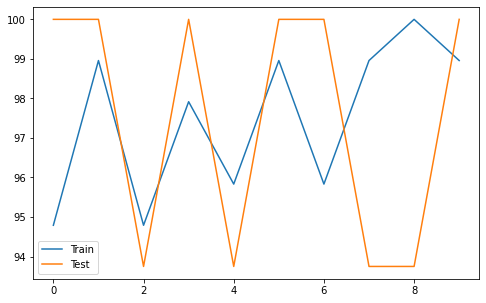

The Accuracy on train was 98.96, and on test was 100.0.


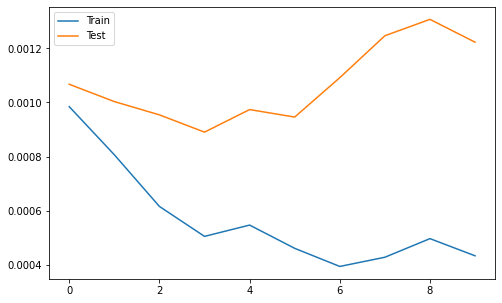

The Losses on train was 0.0, and on test was 0.0.


In [131]:
network_plots(plot_train_accuracy, plot_test_accuracy, 'Accuracy')
network_plots(plot_train_losses, plot_test_losses, 'Losses')

In [132]:
predict_dataset = datasets.MNIST(root="dataset/", train=False, transform=transforms.ToTensor(), download=True)
predict_loader = DataLoader(dataset=test_dataset, batch_size = 1, shuffle=True)

100%|██████████| 10000/10000 [00:09<00:00, 1101.96it/s]


0.9663


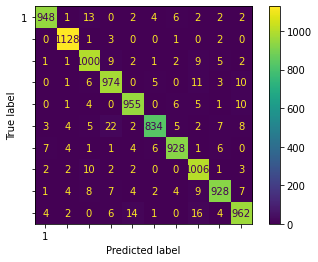

In [134]:
# test_loader
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for x, y in tqdm(predict_loader):
        x = x.to(device=device)
        y = y.to(device=device)
        y = y.cpu().detach().numpy()
        
        x = x.reshape(x.shape[0], -1)
        outputs = model(x)

        predictions = torch.log_softmax(outputs, dim = 1)
        _, predictions = torch.max(predictions, 1)
        predictions = predictions.cpu().detach().numpy()

        y_true.append(y)
        y_pred.append(predictions)

model.train()

conf_matrix = confusion_matrix(
    y_true = y_true,
    y_pred = y_pred
    )
labels = np.unique(y)

print(accuracy_score(y_true, y_pred))


plot_cm = ConfusionMatrixDisplay(
    confusion_matrix = conf_matrix,
    display_labels = labels
    ) \
    .plot()

plt.show()

### CNN

In [394]:
# ploting evaluations
def network_plots(train, test, metric):
    fig, ax = plt.subplots(figsize=(8,5))

    ax.plot(train)
    ax.plot(test)

    ax.legend(('Train', 'Test'), loc="best")
    plt.show()
    print(f"The {metric} on train was {round(train[-1],2)}, and on test was {round(test[-1],2)}.")

In [395]:
class CNN(nn.Module):
    def __init__(self, in_channel, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels = in_channel,
            out_channels = 8,
            kernel_size = (3,3),
            stride = (1,1),
            padding = (1,1)
        )
        self.pool = nn.MaxPool2d(
            kernel_size = (2,2),
            stride = (2,2),
        )
        self.conv2 = nn.Conv2d(
            in_channels = 8,
            out_channels = 16,
            kernel_size = (3,3),
            stride = (1,1),
            padding = (1,1)
        )
        self.fc1 = nn.Linear(16*7*7, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        return x

In [448]:
# hiperparameters
num_epochs = 10
learning_rate = 0.001

# Initialize network
model = CNN(
    in_channel = in_channel, 
    num_classes = num_classes,
    ).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train Network
train_losses = []
valid_losses = []
train_accuracy = []
valid_accuracy = []


for epoch in tqdm(range(num_epochs)):    
    running_loss = 0
    train_acc = 0
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible

        data = data.to(device=device)
        targets = targets.to(device=device)
        
        # forward
        outputs = model(data)
        loss = criterion(outputs, targets)
        
        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

        # forward metrics log
        _, predictions = torch.max(outputs, 1)
        equals = predictions == targets.view(*predictions.shape)
        train_acc += torch.mean(equals.type(torch.FloatTensor))
        running_loss += loss.item()
    else:
        # validation metrics log
        valid_loss = 0
        valid_acc = 0
        with torch.no_grad():
            model.eval()
            for x, y in test_loader:
                x = x.to(device=device)
                y = y.to(device=device)
                outputs = model(x)
                
                _, predictions = torch.max(outputs, 1)

                equals = predictions == y.view(*predictions.shape)
                
                valid_loss += criterion(outputs, y)
                valid_acc += torch.mean(equals.type(torch.FloatTensor))
            
    model.train()
            
    # traking results
    train_accuracy.append((train_acc/len(train_loader)).item())
    valid_accuracy.append((valid_acc/len(test_loader)).item())
    train_losses.append(running_loss/len(train_loader))
    valid_losses.append((valid_loss/len(test_loader)).item())
    
    acct = round(train_accuracy[-1],2)   
    accv = round(valid_accuracy[-1],2)
    lossv = round(valid_losses[-1],2)
    losst = round(train_losses[-1],2)

    print(f" || acc: train {acct}; valid {accv} | loss: train {losst}; valid {lossv}")

 10%|█         | 1/10 [00:18<02:43, 18.12s/it]

 || acc: train 0.89; valid 0.95 | loss: train 0.39; valid 0.15


 20%|██        | 2/10 [00:30<01:57, 14.75s/it]

 || acc: train 0.96; valid 0.97 | loss: train 0.13; valid 0.1


 30%|███       | 3/10 [00:42<01:35, 13.66s/it]

 || acc: train 0.97; valid 0.97 | loss: train 0.1; valid 0.08


 40%|████      | 4/10 [00:55<01:18, 13.13s/it]

 || acc: train 0.98; valid 0.98 | loss: train 0.08; valid 0.06


 50%|█████     | 5/10 [01:07<01:04, 12.87s/it]

 || acc: train 0.98; valid 0.98 | loss: train 0.07; valid 0.06


 60%|██████    | 6/10 [01:19<00:50, 12.71s/it]

 || acc: train 0.98; valid 0.98 | loss: train 0.06; valid 0.06


 70%|███████   | 7/10 [01:32<00:37, 12.56s/it]

 || acc: train 0.98; valid 0.98 | loss: train 0.06; valid 0.05


 80%|████████  | 8/10 [01:44<00:25, 12.52s/it]

 || acc: train 0.98; valid 0.98 | loss: train 0.05; valid 0.05


 90%|█████████ | 9/10 [01:56<00:12, 12.45s/it]

 || acc: train 0.99; valid 0.98 | loss: train 0.05; valid 0.05


100%|██████████| 10/10 [02:09<00:00, 12.94s/it]

 || acc: train 0.99; valid 0.98 | loss: train 0.04; valid 0.05


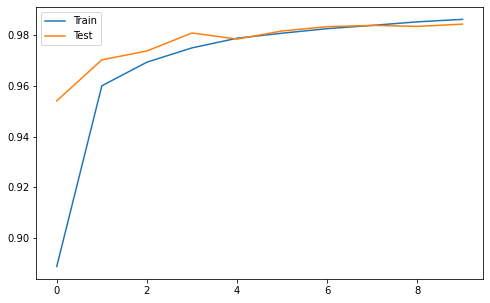

The Accuracy on train was 0.99, and on test was 0.98.


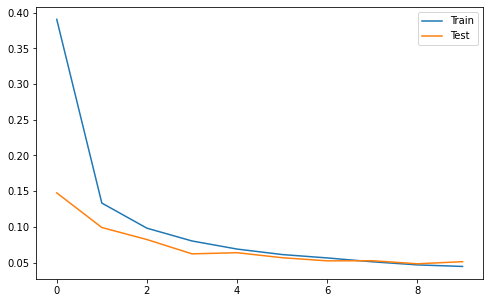

The Losses on train was 0.04, and on test was 0.05.


In [449]:
network_plots(train_accuracy, valid_accuracy, 'Accuracy')
network_plots(train_losses, valid_losses, 'Losses')

In [450]:
predict_dataset = datasets.MNIST(root="dataset/", train=False, transform=transforms.ToTensor(), download=True)
predict_loader = DataLoader(dataset=test_dataset, batch_size = 1, shuffle=True)

100%|██████████| 10000/10000 [00:11<00:00, 858.32it/s]


0.9844


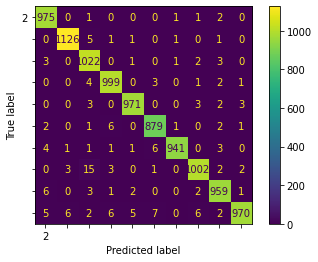

In [451]:
# test_loader
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for x, y in tqdm(predict_loader):
        x = x.to(device=device)
        y = y.to(device=device)
        y = y.cpu().detach().numpy()

        outputs = model(x)

        predictions = torch.log_softmax(outputs, dim = 1)
        _, predictions = torch.max(predictions, 1)
        predictions = predictions.cpu().detach().numpy()

        y_true.append(y)
        y_pred.append(predictions)

model.train()

conf_matrix = confusion_matrix(
    y_true = y_true,
    y_pred = y_pred
    )
labels = np.unique(y)

print(accuracy_score(y_true, y_pred))


plot_cm = ConfusionMatrixDisplay(
    confusion_matrix = conf_matrix,
    display_labels = labels
    ) \
    .plot()

plt.show()

### Kaggle Competition

In [181]:
! kaggle competitions download -c digit-recognizer --force

 65% 10.0M/15.3M [00:00<00:00, 38.0MB/s]
100% 15.3M/15.3M [00:00<00:00, 55.2MB/s]


In [403]:
! unzip digit-recognizer.zip

Archive:  digit-recognizer.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [404]:
test = pd.read_csv("test.csv")

In [405]:
df_sub = pd.read_csv("sample_submission.csv")

#### Submission

In [406]:
class import_mnist(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image = self.data.iloc[index].values.astype(np.uint8).reshape((28, 28, 1))
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

sub_dataset = import_mnist(test, transform=transform)

sub_loader = DataLoader(
    dataset = sub_dataset,
    batch_size = 1,
    shuffle = False
    )

In [407]:
# submission prediction
model.eval()
y_pred = []
with torch.no_grad():
    for x in tqdm(sub_loader):
        x = x.to(device=device)

        outputs = model(x)

        predictions = torch.log_softmax(outputs, dim = 1)
        _, predictions = torch.max(predictions, 1)
        predictions = predictions[0].cpu().detach().numpy()
        y_pred.append(predictions)

model.train()

100%|██████████| 28000/28000 [00:44<00:00, 627.14it/s]

[array(2), array(0), array(9), array(0), array(3)]


In [408]:
submission = pd.DataFrame({'ImageId': df_sub['ImageId'], 'Label': y_pred})
submission.to_csv('submission.csv', index=False)

In [411]:
! kaggle competitions submit -c digit-recognizer -f submission.csv -m "No mensage."

100% 208k/208k [00:01<00:00, 144kB/s]
Successfully submitted to Digit Recognizer

0.81767

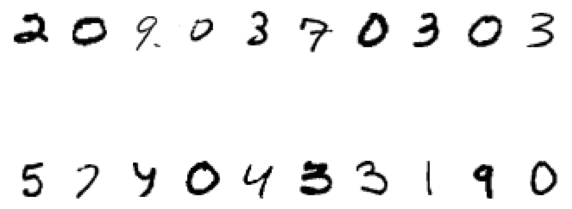

In [409]:
# Viewing data examples used for validation
fig, axis = plt.subplots(2, 10, figsize=(10, 5))
images = iter(sub_loader)

for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image = sub_dataset[i]
        ax.imshow(image.view(28, 28), cmap='binary') # add image
        ax.axis('off')

In [410]:
submission.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
ImageId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Label,2,0,9,0,3,7,0,3,0,3,5,7,9,0,7,3,3,0,9,0


# 3ª Questão

In [455]:
# dataset parameters
in_channel = 3
input_size = 50000
num_classes = 10
batch_size = 100

In [456]:
train_dataset = datasets.CIFAR10(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.CIFAR10(root="dataset/", train=False, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [457]:
len(train_dataset), len(test_dataset)

(50000, 10000)

In [458]:
# ploting evaluations
def network_plots(train, test, metric):
    fig, ax = plt.subplots(figsize=(8,5))

    ax.plot(train)
    ax.plot(test)

    ax.legend(('Train', 'Test'), loc="best")
    plt.show()
    print(f"The {metric} on train was {round(train[-1],2)}, and on test was {round(test[-1],2)}.")

In [474]:
# reason for the kernel
input_featrues = 32
padding = 1
kernel_size = 3
stride = 1

kernel = (input_featrues+2*padding-kernel_size)/stride+1

MaxPool_output = 32/2/2/2

print(kernel, MaxPool_output)

32.0 4.0


In [507]:
# modelo da LeNet com mais uma camada full conected
class LeNet(nn.Module):
    def __init__(self, in_channel, num_classes):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels = in_channel,
            out_channels = 16,
            kernel_size = (3,3),
            stride = (1,1),
            padding = (1,1)
        )
        self.conv2 = nn.Conv2d(
            in_channels = 16,
            out_channels = 32,
            kernel_size = (3,3),
            stride = (1,1),
            padding = (1,1)
        )
        self.conv3 = nn.Conv2d(
            in_channels = 32,
            out_channels = 64,
            kernel_size = (3,3),
            stride = (1,1),
            padding = (1,1)
        )
        self.pool = nn.MaxPool2d(
            kernel_size = (2,2),
            stride = (2,2),
        )
        self.fc1 = nn.Linear(64*4*4, 500)
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, num_classes)
        self.drop1 = nn.Dropout(0.1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1) # flatten our images to 1D to input it to the fully connected layers
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop1(x)
        x = self.fc3(x)
        return x

In [508]:
model = LeNet(3,10)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
  (drop1): Dropout(p=0.1, inplace=False)
)

In [509]:
# hiperparameters
num_epochs = 10
learning_rate = 0.001

# Initialize network
model = LeNet(
    in_channel = in_channel, 
    num_classes = num_classes,
    ).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train Network
train_losses = []
valid_losses = []
train_accuracy = []
valid_accuracy = []


for epoch in tqdm(range(num_epochs)):    
    running_loss = 0
    train_acc = 0
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible

        data = data.to(device=device)
        targets = targets.to(device=device)
        
        # forward
        outputs = model(data)
        loss = criterion(outputs, targets)
        
        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

        # forward metrics log
        _, predictions = torch.max(outputs, 1)
        equals = predictions == targets.view(*predictions.shape)
        train_acc += torch.mean(equals.type(torch.FloatTensor))
        running_loss += loss.item()
    else:
        # validation metrics log
        valid_loss = 0
        valid_acc = 0
        with torch.no_grad():
            model.eval()
            for x, y in test_loader:
                x = x.to(device=device)
                y = y.to(device=device)
                outputs = model(x)
                
                _, predictions = torch.max(outputs, 1)

                equals = predictions == y.view(*predictions.shape)
                
                valid_loss += criterion(outputs, y)
                valid_acc += torch.mean(equals.type(torch.FloatTensor))
            
    model.train()
            
    # traking results
    train_accuracy.append((train_acc/len(train_loader)).item())
    valid_accuracy.append((valid_acc/len(test_loader)).item())
    train_losses.append(running_loss/len(train_loader))
    valid_losses.append((valid_loss/len(test_loader)).item())
    
    acct = round(train_accuracy[-1],2)   
    accv = round(valid_accuracy[-1],2)
    lossv = round(valid_losses[-1],2)
    losst = round(train_losses[-1],2)

    print(f" || acc: train {acct}; valid {accv} | loss: train {losst}; valid {lossv}")

 10%|█         | 1/10 [00:17<02:38, 17.56s/it]

 || acc: train 0.39; valid 0.47 | loss: train 1.66; valid 1.46


 20%|██        | 2/10 [00:35<02:19, 17.50s/it]

 || acc: train 0.52; valid 0.58 | loss: train 1.32; valid 1.17


 30%|███       | 3/10 [00:52<02:02, 17.50s/it]

 || acc: train 0.59; valid 0.63 | loss: train 1.13; valid 1.04


 40%|████      | 4/10 [01:10<01:45, 17.53s/it]

 || acc: train 0.65; valid 0.65 | loss: train 1.0; valid 0.99


 50%|█████     | 5/10 [01:27<01:27, 17.55s/it]

 || acc: train 0.68; valid 0.68 | loss: train 0.9; valid 0.91


 60%|██████    | 6/10 [01:45<01:10, 17.54s/it]

 || acc: train 0.71; valid 0.68 | loss: train 0.82; valid 0.9


 70%|███████   | 7/10 [02:02<00:52, 17.55s/it]

 || acc: train 0.74; valid 0.68 | loss: train 0.74; valid 0.91


 80%|████████  | 8/10 [02:20<00:35, 17.58s/it]

 || acc: train 0.76; valid 0.71 | loss: train 0.69; valid 0.84


 90%|█████████ | 9/10 [02:37<00:17, 17.55s/it]

 || acc: train 0.78; valid 0.73 | loss: train 0.62; valid 0.81


100%|██████████| 10/10 [02:55<00:00, 17.54s/it]

 || acc: train 0.8; valid 0.72 | loss: train 0.57; valid 0.82


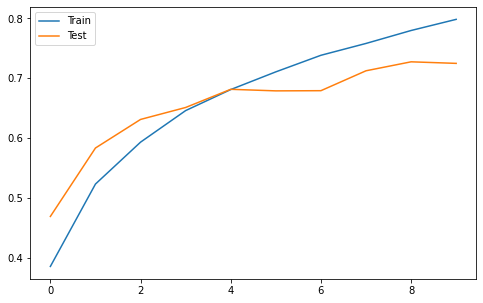

The Accuracy on train was 0.8, and on test was 0.72.


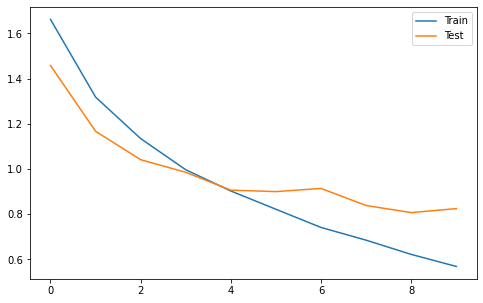

The Losses on train was 0.57, and on test was 0.82.


In [510]:
network_plots(train_accuracy, valid_accuracy, 'Accuracy')
network_plots(train_losses, valid_losses, 'Losses')

In [511]:
predict_dataset = datasets.CIFAR10(root="dataset/", train=False, transform=transforms.ToTensor(), download=True)
predict_loader = DataLoader(dataset=test_dataset, batch_size = 1, shuffle=True)

Files already downloaded and verified


100%|██████████| 10000/10000 [00:18<00:00, 544.49it/s]


0.7249


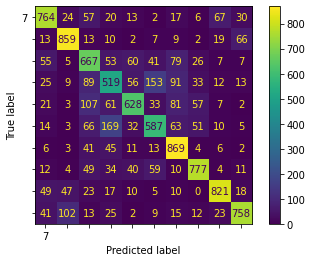

In [512]:
# test_loader
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for x, y in tqdm(predict_loader):
        x = x.to(device=device)
        y = y.to(device=device)
        y = y.cpu().detach().numpy()

        outputs = model(x)

        predictions = torch.log_softmax(outputs, dim = 1)
        _, predictions = torch.max(predictions, 1)
        predictions = predictions.cpu().detach().numpy()

        y_true.append(y)
        y_pred.append(predictions)

model.train()

conf_matrix = confusion_matrix(
    y_true = y_true,
    y_pred = y_pred
    )
labels = np.unique(y)

print(accuracy_score(y_true, y_pred))


plot_cm = ConfusionMatrixDisplay(
    confusion_matrix = conf_matrix,
    display_labels = labels
    ) \
    .plot()

plt.show()

In [ ]:
# Viewing data examples used for validation
fig, axis = plt.subplots(2, 10, figsize=(10, 5))
images = iter(sub_loader)

for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image = sub_dataset[i]
        ax.imshow(image.view(28, 28), cmap='binary') # add image
        ax.axis('off')